## 数据处理

### 1）将monthly数据处理成weekly。拆分逻辑为每个month平拆4行，周sales/TV imp/OTV imp的值为月度数据的1/4, 周price为月度数据平拆。

In [101]:
import pandas as pd

# 读入monthly_data_test数据
monthly_data = pd.read_excel('monthly_data_test.xlsx')

# 数据拆分为周数据
weekly_data = pd.DataFrame(columns=monthly_data.columns)
for i, row in monthly_data.iterrows():
    for j in range(4):
        week_row = row.copy()
        week_row['date'] = str(row['date'])[:7] + f"-wk{j+1}"
        week_row['sales'] = row['sales'] / 4
        week_row['TV_IMP'] = row['TV_IMP'] / 4
        week_row['OTV_IMP'] = row['OTV_IMP'] / 4
        weekly_data = weekly_data.append(week_row, ignore_index=True)

# 保存处理后的周数据
weekly_data.to_excel('weekly_data_test.xlsx', index=False)
weekly_data.head()

,geogkey,date,sales,TV_IMP,OTV_IMP,Brand_Price
0,Beijing,2019-01-wk1,722731.495733,562081.455895,1666220.50,100.148126
1,Beijing,2019-01-wk2,722731.495733,562081.455895,1666220.50,100.148126
2,Beijing,2019-01-wk3,722731.495733,562081.455895,1666220.50,100.148126
3,Beijing,2019-01-wk4,722731.495733,562081.455895,1666220.50,100.148126
4,Beijing,2019-02-wk1,507755.851559,709215.119999,1508451.25,102.083625


### 2）对于媒体投放，商业上我们会考虑retention, 即上一周的投放效果会有部分作用于下一周。假设HL（半衰期）=1，即一周后媒体投放效果为上一周的一半。请基于拆完周的TV_IMP和OTV_IMP, 用代码分别计算retention之后的TV_IMP_R和OTV_IMP_R, 并解释计算逻辑。

In [102]:
# 计算TV_IMP_R和OTV_IMP_R
TV_IMP_R = []
OTV_IMP_R = []
for i, row in weekly_data.iterrows():
    if i == 0:
        TV_IMP_R.append(row['TV_IMP'])
        OTV_IMP_R.append(row['OTV_IMP'])
    else:
        TV_IMP_R.append(row['TV_IMP'] + TV_IMP_R[i-1] / 2)
        OTV_IMP_R.append(row['OTV_IMP'] + OTV_IMP_R[i-1] / 2)

weekly_data['TV_IMP_R'] = TV_IMP_R
weekly_data['OTV_IMP_R'] = OTV_IMP_R

# 保存weekly数据
weekly_data.to_excel('weekly_data_result.xlsx', index=False)
weekly_data.head()

,geogkey,date,sales,TV_IMP,OTV_IMP,Brand_Price,TV_IMP_R,OTV_IMP_R
0,Beijing,2019-01-wk1,722731.495733,562081.455895,1666220.50,100.148126,5.620815e+05,1.666220e+06
1,Beijing,2019-01-wk2,722731.495733,562081.455895,1666220.50,100.148126,8.431222e+05,2.499331e+06
2,Beijing,2019-01-wk3,722731.495733,562081.455895,1666220.50,100.148126,9.836425e+05,2.915886e+06
3,Beijing,2019-01-wk4,722731.495733,562081.455895,1666220.50,100.148126,1.053903e+06,3.124163e+06
4,Beijing,2019-02-wk1,507755.851559,709215.119999,1508451.25,102.083625,1.236166e+06,3.070533e+06


计算逻辑：

对于TV_IMP_R和OTV_IMP_R，用两个数组分别存储

假设TV_IMP和OTV_IMP是某一周的投放量。假设HL（半衰期）=1，即一周后媒体投放效果为上一周的一半。

那么下一周的TV_IMP_R就是上一周的TV_IMP * (1/2), 即TV_IMP_R = TV_IMP * 0.5。

下一周的OTV_IMP_R就是上一周的OTV_IMP * (1/2), 即OTV_IMP_R = OTV_IMP * 0.5。

重复以上步骤，计算出每一周的TV_IMP_R和OTV_IMP_R。

## 分析&模型实现

### 1. 数据描述与准备

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

kol_data = pd.read_excel("KOL_data_test.xlsx", skiprows=1)
kol_data.head()

,达人 ID,粉丝数,获赞与收藏,图文笔记一口价,视频笔记一口价,发布笔记数,千赞笔记比例,百赞笔记比例,阅读中位数,互动中位数,...,粉丝量变化幅度,活跃粉丝占比,互动粉丝占比,男性占比,女性占比,小于18岁占比,18-24岁占比,25-34岁占比,35-44岁占比,大于44岁占比
0,446,1487,95474,599,699,32,12.50%,62.50%,16410,661,...,0.0690,91.30%,3.90%,0.423110,0.576890,0.019114,0.247611,0.524761,0.139878,0.068636
1,610,1751,4907,270,490,2,NaN,50.00%,474,68,...,-0.0096,82.90%,NaN,0.974202,0.025798,0.050916,0.604209,0.300747,0.033944,0.010183
2,539,2043,92975,180,0,3,NaN,NaN,142,25,...,-0.0063,74.90%,0.40%,0.024361,0.975639,0.494355,0.377302,0.076649,0.034462,0.017231
3,405,2202,83842,100,120,77,5.20%,20.80%,1457,54,...,0.2066,94.90%,16.50%,0.050748,0.949252,0.193910,0.631410,0.144231,0.018162,0.012286
4,796,2749,1938,500,800,4,NaN,NaN,58,3,...,0.0007,1.70%,NaN,0.560440,0.439560,0.010989,0.065934,0.774725,0.115385,0.032967


In [104]:
kol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   达人 ID     802 non-null    int64  
 1   粉丝数       802 non-null    int64  
 2   获赞与收藏     802 non-null    int64  
 3   图文笔记一口价   802 non-null    int64  
 4   视频笔记一口价   802 non-null    int64  
 5   发布笔记数     802 non-null    int64  
 6   千赞笔记比例    578 non-null    object 
 7   百赞笔记比例    749 non-null    object 
 8   阅读中位数     802 non-null    int64  
 9   互动中位数     802 non-null    int64  
 10  互动率       788 non-null    object 
 11  视频完播率     615 non-null    object 
 12  粉丝增量      802 non-null    int64  
 13  粉丝量变化幅度   802 non-null    float64
 14  活跃粉丝占比    802 non-null    object 
 15  互动粉丝占比    691 non-null    object 
 16  男性占比      802 non-null    float64
 17  女性占比      802 non-null    float64
 18  小于18岁占比   802 non-null    float64
 19  18-24岁占比  802 non-null    float64
 20  25-34岁占比  802 non-null    float6

In [105]:
# 将object类型转换为float类型
kol_data = kol_data.replace('%', '', regex=True)
kol_data = kol_data.astype({'千赞笔记比例': float, '百赞笔记比例': float, '互动率': float, '视频完播率': float, '活跃粉丝占比': float, '互动粉丝占比': float})
kol_data ['千赞笔记比例']=kol_data ['千赞笔记比例']/100
kol_data ['百赞笔记比例']=kol_data ['百赞笔记比例']/100
kol_data ['互动率']=kol_data ['互动率']/100
kol_data ['视频完播率']=kol_data ['视频完播率']/100
kol_data ['活跃粉丝占比']=kol_data ['活跃粉丝占比']/100
kol_data ['互动粉丝占比']=kol_data ['互动粉丝占比']/100

In [106]:
kol_data.head()

,达人 ID,粉丝数,获赞与收藏,图文笔记一口价,视频笔记一口价,发布笔记数,千赞笔记比例,百赞笔记比例,阅读中位数,互动中位数,...,粉丝量变化幅度,活跃粉丝占比,互动粉丝占比,男性占比,女性占比,小于18岁占比,18-24岁占比,25-34岁占比,35-44岁占比,大于44岁占比
0,446,1487,95474,599,699,32,0.125,0.625,16410,661,...,0.0690,0.913,0.039,0.423110,0.576890,0.019114,0.247611,0.524761,0.139878,0.068636
1,610,1751,4907,270,490,2,NaN,0.500,474,68,...,-0.0096,0.829,NaN,0.974202,0.025798,0.050916,0.604209,0.300747,0.033944,0.010183
2,539,2043,92975,180,0,3,NaN,NaN,142,25,...,-0.0063,0.749,0.004,0.024361,0.975639,0.494355,0.377302,0.076649,0.034462,0.017231
3,405,2202,83842,100,120,77,0.052,0.208,1457,54,...,0.2066,0.949,0.165,0.050748,0.949252,0.193910,0.631410,0.144231,0.018162,0.012286
4,796,2749,1938,500,800,4,NaN,NaN,58,3,...,0.0007,0.017,NaN,0.560440,0.439560,0.010989,0.065934,0.774725,0.115385,0.032967


### 1）对于所有指标，出现空值的，自动填0。

In [107]:
kol_data = kol_data.fillna(0)

### 2）如果我的核心商业指标是“阅读中位数”, 哪些达人的数据维度会影响这个指标？是否可以构建一个模型输出各个维度的影响系数？

#### step 1. 标准化

In [108]:
from sklearn import preprocessing 

features_columns = [col for col in kol_data.columns if col not in ['阅读中位数']]

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler = min_max_scaler.fit(kol_data[features_columns])

kol_data_scaler = min_max_scaler.transform(kol_data[features_columns])

kol_data_scaler = pd.DataFrame(kol_data_scaler)
kol_data_scaler.columns = features_columns

kol_data_scaler['阅读中位数'] = kol_data['阅读中位数']

In [109]:
kol_data_scaler.describe()

,达人 ID,粉丝数,获赞与收藏,图文笔记一口价,视频笔记一口价,发布笔记数,千赞笔记比例,百赞笔记比例,互动中位数,互动率,...,活跃粉丝占比,互动粉丝占比,男性占比,女性占比,小于18岁占比,18-24岁占比,25-34岁占比,35-44岁占比,大于44岁占比,阅读中位数
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,...,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,8.020000e+02
mean,0.500000,0.086265,0.047107,0.074023,0.091124,0.169171,0.354774,0.803909,0.013082,0.099106,...,0.655934,0.070479,0.102414,0.897586,0.239035,0.332425,0.387785,0.240779,0.077261,5.269463e+04
std,0.289216,0.112551,0.080371,0.083382,0.099810,0.139811,0.348765,0.303492,0.046816,0.092129,...,0.272298,0.101486,0.109909,0.109909,0.268094,0.182042,0.208610,0.162163,0.100602,1.781963e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.250000,0.028082,0.010010,0.025926,0.032143,0.066225,0.000000,0.750000,0.001233,0.040682,...,0.496891,0.005988,0.036253,0.868696,0.054270,0.195195,0.226032,0.113611,0.028058,7.243250e+03
50%,0.500000,0.054706,0.024123,0.055556,0.064286,0.135762,0.259000,0.959500,0.003535,0.076772,...,0.756995,0.035928,0.066100,0.933900,0.112787,0.306540,0.425104,0.203861,0.053271,2.016150e+04
75%,0.750000,0.099948,0.051313,0.092593,0.114286,0.225166,0.649250,1.000000,0.009542,0.129921,...,0.872539,0.092066,0.131304,0.963747,0.322229,0.447606,0.545057,0.330834,0.090020,4.502125e+04
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.776449e+06


#### step 2. 异常值分析

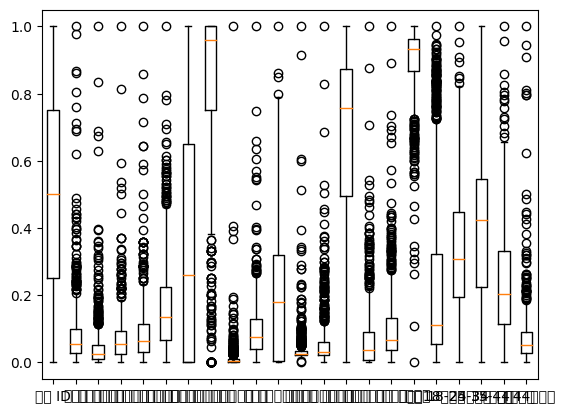

In [110]:
import warnings
warnings.filterwarnings("ignore")
plt.figure()
plt.boxplot(x=kol_data_scaler.values[:, :22],labels=kol_data_scaler.columns[:22])
plt.show()

In [111]:
# 删除异常值
kol_data_scaler = kol_data_scaler[
    (kol_data_scaler['粉丝数'] < 0.6) & 
    (kol_data_scaler['获赞与收藏'] < 0.6) & 
    (kol_data_scaler['图文笔记一口价'] < 0.4) & 
    (kol_data_scaler['视频笔记一口价'] < 0.4) & 
    (kol_data_scaler['发布笔记数'] < 0.6) & 
    (kol_data_scaler['互动中位数'] < 0.2) & 
    (kol_data_scaler['互动率'] < 0.4) & 
    (kol_data_scaler['视频完播率'] < 0.8) & 
    (kol_data_scaler['粉丝增量'] < 0.4) & 
    (kol_data_scaler['粉丝量变化幅度'] < 0.6) & 
    (kol_data_scaler['互动粉丝占比'] < 0.6) & 
    (kol_data_scaler['男性占比'] < 0.5) & 
    (kol_data_scaler['女性占比'] > 0.4) & 
    (kol_data_scaler['18-24岁占比'] < 0.9) & 
    (kol_data_scaler['35-44岁占比'] < 0.8) & 
    (kol_data_scaler['大于44岁占比'] < 0.5) ]

#### step 3.1 相关性分析

In [112]:
# 因素的相关性
kol_data_scaler.corr(method='spearman')

,达人 ID,粉丝数,获赞与收藏,图文笔记一口价,视频笔记一口价,发布笔记数,千赞笔记比例,百赞笔记比例,互动中位数,互动率,...,活跃粉丝占比,互动粉丝占比,男性占比,女性占比,小于18岁占比,18-24岁占比,25-34岁占比,35-44岁占比,大于44岁占比,阅读中位数
达人 ID,1.000000,-0.002167,0.033390,-0.008507,-0.030226,-0.015977,0.087659,0.084982,0.097226,0.091099,...,0.107065,0.095720,-0.016316,0.016316,0.053550,-0.001591,-0.062977,0.011679,0.038950,0.061360
粉丝数,-0.002167,1.000000,0.725137,0.737302,0.784191,0.049001,0.501324,0.490399,0.584211,0.064014,...,-0.023315,0.213225,-0.085543,0.085543,0.063042,0.003629,-0.056847,-0.007005,-0.027908,0.636111
获赞与收藏,0.033390,0.725137,1.000000,0.412052,0.422716,0.255788,0.667538,0.386718,0.650990,0.384209,...,0.229458,0.442349,-0.214312,0.214312,0.241495,0.114949,-0.219038,-0.092272,-0.021004,0.513684
图文笔记一口价,-0.008507,0.737302,0.412052,1.000000,0.892191,-0.092273,0.249960,0.432936,0.371209,-0.126024,...,-0.144636,0.038160,0.018835,-0.018835,-0.098446,-0.006382,0.090889,0.076763,-0.011356,0.504605
视频笔记一口价,-0.030226,0.784191,0.422716,0.892191,1.000000,-0.067755,0.333363,0.494298,0.436127,-0.132752,...,-0.133785,0.115343,-0.008540,0.008540,-0.025005,-0.015779,0.029077,0.039880,-0.029623,0.577419
发布笔记数,-0.015977,0.049001,0.255788,-0.092273,-0.067755,1.000000,0.335380,0.090630,0.229390,0.271152,...,0.436926,0.576462,-0.200692,0.200692,0.071896,0.261729,-0.105294,-0.240524,-0.228167,0.096316
千赞笔记比例,0.087659,0.501324,0.667538,0.249960,0.333363,0.335380,1.000000,0.576264,0.902866,0.424003,...,0.449005,0.784893,-0.278724,0.278724,0.350748,0.208960,-0.319528,-0.248621,-0.150441,0.734230
百赞笔记比例,0.084982,0.490399,0.386718,0.432936,0.494298,0.090630,0.576264,1.000000,0.721127,0.069320,...,0.175784,0.435852,-0.095550,0.095550,0.098673,0.096325,-0.074501,-0.053465,-0.076315,0.728866
互动中位数,0.097226,0.584211,0.650990,0.371209,0.436127,0.229390,0.902866,0.721127,1.000000,0.362882,...,0.349565,0.720094,-0.207703,0.207703,0.269507,0.124568,-0.237778,-0.131584,-0.050841,0.850061
互动率,0.091099,0.064014,0.384209,-0.126024,-0.132752,0.271152,0.424003,0.069320,0.362882,1.000000,...,0.190084,0.359793,-0.122200,0.122200,0.294873,0.066893,-0.221552,-0.116162,0.037045,-0.042037


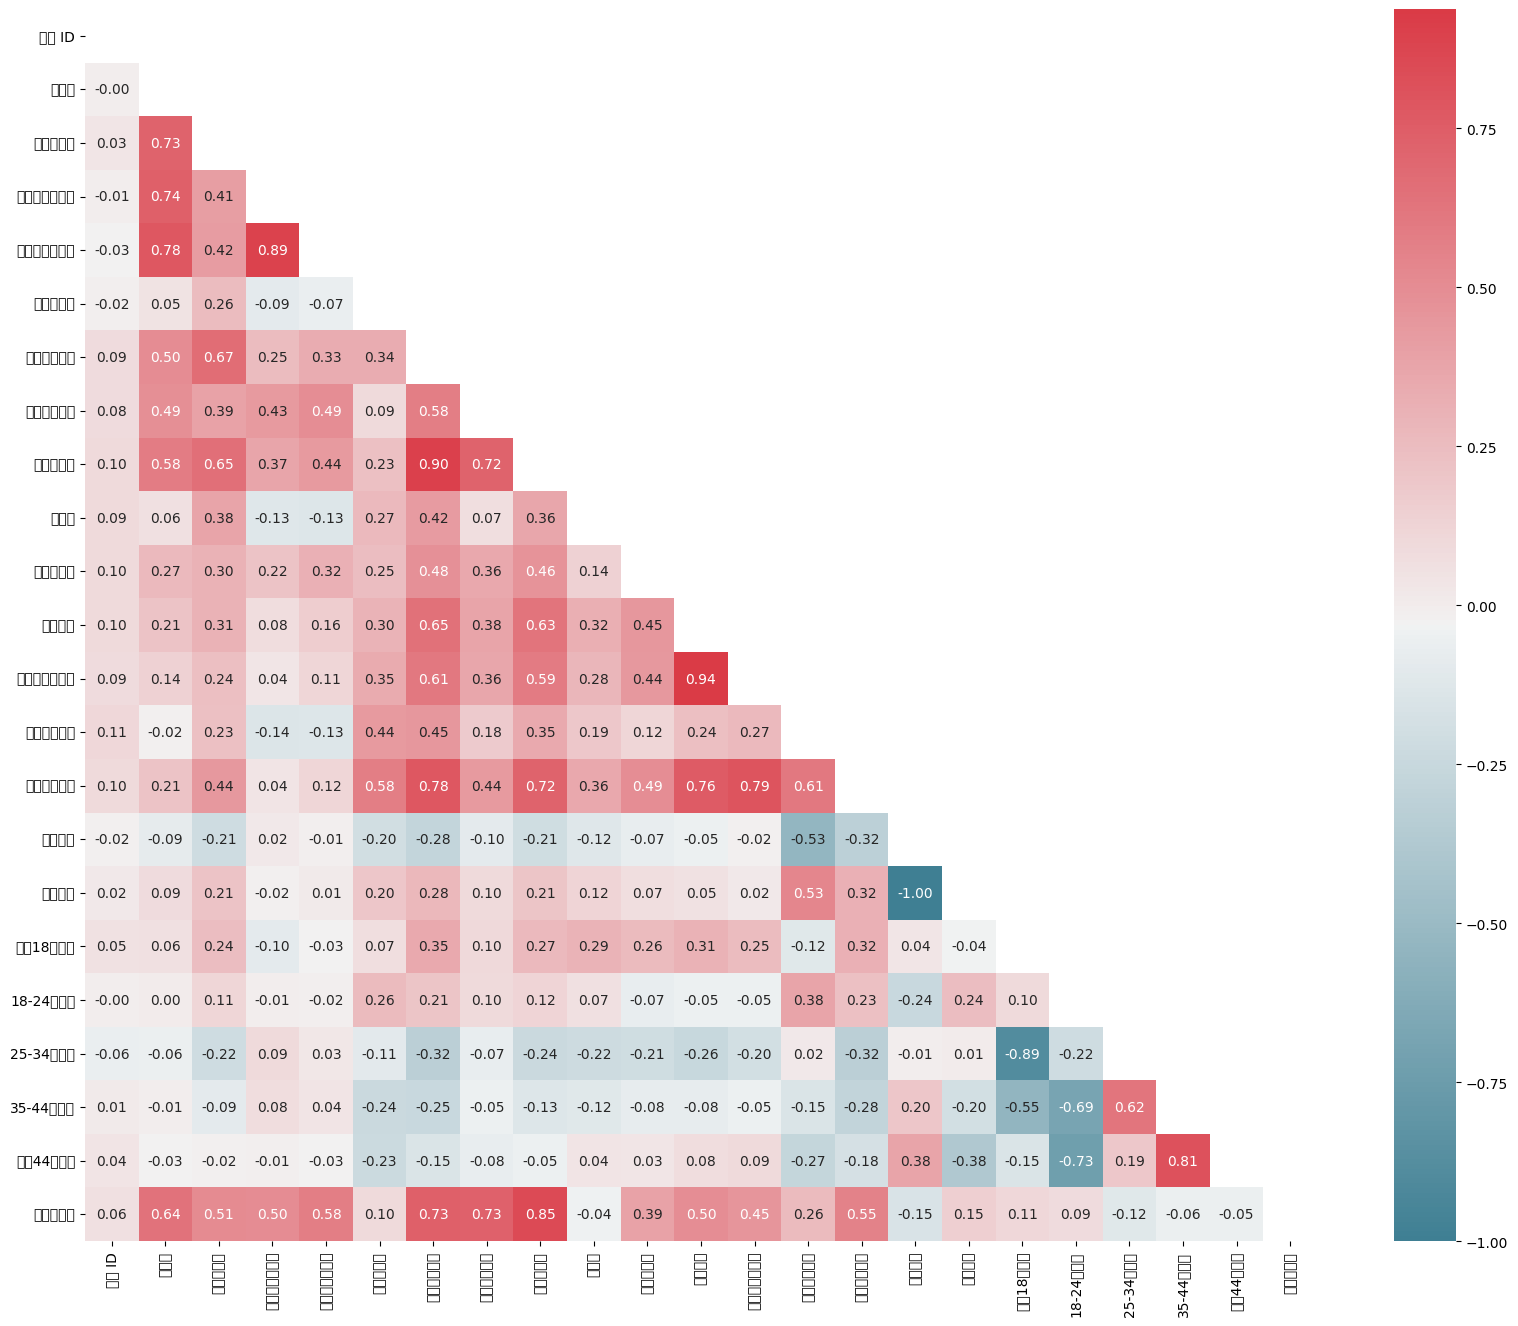

In [113]:
# 可视化
import seaborn as sns
from scipy import stats

plt.figure(figsize=(20, 16))  
column = kol_data_scaler.columns.tolist()  
mcorr = kol_data_scaler[column].corr(method="spearman")  
mask = np.zeros_like(mcorr)  
mask[np.triu_indices_from(mask)] = True  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

#### step 3.2 特征降维

In [114]:
# 相关性分析
mcorr=mcorr.abs()
numerical_corr=mcorr[mcorr['阅读中位数']>0.1]['阅读中位数']
print(numerical_corr.sort_values(ascending=False))

index0 = numerical_corr.sort_values(ascending=False).index
print(kol_data_scaler[index0].corr('spearman'))

阅读中位数       1.000000
互动中位数       0.850061
千赞笔记比例      0.734230
百赞笔记比例      0.728866
粉丝数         0.636111
视频笔记一口价     0.577419
互动粉丝占比      0.553832
获赞与收藏       0.513684
图文笔记一口价     0.504605
粉丝增量        0.497309
粉丝量变化幅度     0.453527
视频完播率       0.389059
活跃粉丝占比      0.262269
男性占比        0.154685
女性占比        0.154685
25-34岁占比    0.116291
小于18岁占比     0.109353
Name: 阅读中位数, dtype: float64
             阅读中位数     互动中位数    千赞笔记比例    百赞笔记比例       粉丝数   视频笔记一口价  \
阅读中位数     1.000000  0.850061  0.734230  0.728866  0.636111  0.577419   
互动中位数     0.850061  1.000000  0.902866  0.721127  0.584211  0.436127   
千赞笔记比例    0.734230  0.902866  1.000000  0.576264  0.501324  0.333363   
百赞笔记比例    0.728866  0.721127  0.576264  1.000000  0.490399  0.494298   
粉丝数       0.636111  0.584211  0.501324  0.490399  1.000000  0.784191   
视频笔记一口价   0.577419  0.436127  0.333363  0.494298  0.784191  1.000000   
互动粉丝占比    0.553832  0.720094  0.784893  0.435852  0.213225  0.115343   
获赞与收藏     0.513684  0.650990  0.667538 

#### step 3.3 相关性筛选

In [115]:
features_corr = numerical_corr.sort_values(ascending=False).reset_index()
features_corr.columns = ['features_and_target', 'corr']
features_corr_select = features_corr[features_corr['corr']>0.3] # 筛选出大于相关性大于0.3的特征
print(features_corr_select)
select_features = [col for col in features_corr_select['features_and_target'] if col not in ['阅读中位数']]
new_kol_data_corr_select = kol_data_scaler[select_features+['阅读中位数']]

   features_and_target      corr
0                阅读中位数  1.000000
1                互动中位数  0.850061
2               千赞笔记比例  0.734230
3               百赞笔记比例  0.728866
4                  粉丝数  0.636111
5              视频笔记一口价  0.577419
6               互动粉丝占比  0.553832
7                获赞与收藏  0.513684
8              图文笔记一口价  0.504605
9                 粉丝增量  0.497309
10             粉丝量变化幅度  0.453527
11               视频完播率  0.389059


### 3）如果“阅读中位数”>5000认为达人表现合格，请构建一个分类模型为每个达人打分，并输出特征重要性。

#### step 1. 分割数据集

In [116]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据预处理
kol_data = kol_data.drop("达人 ID", axis=1)
kol_data["performance"] = (kol_data["阅读中位数"] > 5000).astype(int)

# 分离特征和目标变量
X = kol_data.drop(["performance","阅读中位数"], axis=1)
y = kol_data["performance"]

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

#### step 2. 构建不同分类模型

##### (1) 逻辑回归

In [117]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()
model1.fit(X_train, y_train)

# 预测
y_pred1 = model1.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred1)
print("模型的准确率为：", accuracy)

# 输出特征重要性
coefs = model1.coef_[0]
print("特征重要性：", coefs)

模型的准确率为： 0.8132780082987552
特征重要性： [ 1.31500525e-06 -1.68168318e-07  2.62386615e-05 -2.77530535e-05
 -5.87078511e-05  1.21278854e-06  2.52387686e-06  4.48812399e-03
 -9.22780701e-07 -1.15518931e-07 -4.22050652e-05  2.25267704e-10
 -5.29772131e-08  5.04573509e-08 -1.10916588e-06 -2.93771365e-06
 -1.81996795e-06 -6.58475523e-07 -7.91017510e-07 -5.36157654e-07
 -2.41260898e-07]


In [118]:
# 将特征对应的系数和特征名称合并在一起
importances = [(feature, coef) for feature, coef in zip(X.columns, coefs)]

# 按照系数的绝对值从大到小排序
importances = sorted(importances, key=lambda x: abs(x[1]), reverse=True)

# 输出排序后的特征重要性
for feature, coef in importances:
    print(f"{feature}: {coef}")

互动中位数: 0.0044881239882209375
发布笔记数: -5.8707851126032106e-05
粉丝增量: -4.2205065174057516e-05
视频笔记一口价: -2.775305351252666e-05
图文笔记一口价: 2.6238661500928885e-05
女性占比: -2.9377136548519424e-06
百赞笔记比例: 2.523876863172036e-06
小于18岁占比: -1.819967951852408e-06
粉丝数: 1.3150052460230227e-06
千赞笔记比例: 1.2127885397786815e-06
男性占比: -1.1091658829110242e-06
互动率: -9.227807005975313e-07
25-34岁占比: -7.910175104582173e-07
18-24岁占比: -6.584755231371284e-07
35-44岁占比: -5.361576539510152e-07
大于44岁占比: -2.412608983621636e-07
获赞与收藏: -1.6816831773113167e-07
视频完播率: -1.1551893118969786e-07
活跃粉丝占比: -5.2977213118844185e-08
互动粉丝占比: 5.045735085055762e-08
粉丝量变化幅度: 2.252677036474693e-10


##### (2) 随机森林

In [119]:
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)

# 预测
y_pred2 = model2.predict(X_test)

# 评估模型
accuracy = accuracy_score(y_test, y_pred2)
print("模型的准确率为：", accuracy)

# 输出特征重要性
importance = model2.feature_importances_
print("特征重要性：", importance)

模型的准确率为： 0.9377593360995851
特征重要性： [0.06744453 0.05399554 0.04916892 0.06572254 0.02258985 0.05779051
 0.17686586 0.20924902 0.06332458 0.01921676 0.02849762 0.0186377
 0.03027053 0.02129647 0.01507162 0.01613644 0.02107852 0.01518317
 0.01505102 0.01613883 0.01726996]


In [120]:
# 将特征对应的系数和特征名称合并在一起
importances = [(feature, importance) for feature, importance in zip(X.columns, importance)]

# 按照系数的绝对值从大到小排序
importances = sorted(importances, key=lambda x: abs(x[1]), reverse=True)

# 输出排序后的特征重要性
for feature, coef in importances:
    print(f"{feature}: {coef}")

互动中位数: 0.2092490182143298
百赞笔记比例: 0.17686586381897443
粉丝数: 0.06744453006338565
视频笔记一口价: 0.06572254138158233
互动率: 0.06332457795649807
千赞笔记比例: 0.057790505970276435
获赞与收藏: 0.05399554437566248
图文笔记一口价: 0.0491689236531394
活跃粉丝占比: 0.030270530470662683
粉丝增量: 0.02849762067428864
发布笔记数: 0.022589850162712997
互动粉丝占比: 0.021296466111442112
小于18岁占比: 0.021078516055201647
视频完播率: 0.01921675871266814
粉丝量变化幅度: 0.01863770489282236
大于44岁占比: 0.017269963036489717
35-44岁占比: 0.01613883193799235
女性占比: 0.01613643744463956
18-24岁占比: 0.015183170100897063
男性占比: 0.01507162447891889
25-34岁占比: 0.01505102048741525


##### （3）SVM 支持向量机

In [121]:
# from sklearn.svm import SVC

# model3 = SVC(kernel='linear')
# model3.fit(X_train, y_train)

# # 模型评估
# y_pred3 = model3.predict(X_test)
# print("Accuracy: ", accuracy_score(y_test, y_pred3))

# # 特征重要性
# coefs = model3.coef_[0]

# # 输出特征重要性
# print("Feature importance: ", coefs)

##### (4) 决策树

In [122]:
from sklearn.tree import DecisionTreeClassifier

model4 = DecisionTreeClassifier()
model4.fit(X_train, y_train)

# 预测
y_pred4 = model4.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred4))

# 输出特征重要性
importances = model4.feature_importances_
print("Feature importances:", importances)

Accuracy: 0.9128630705394191
Feature importances: [0.02657453 0.         0.00923875 0.         0.01921353 0.00460756
 0.03174144 0.63408226 0.1607451  0.02059714 0.01041511 0.
 0.01221232 0.         0.         0.0320738  0.02207401 0.01642444
 0.         0.         0.        ]


In [123]:
# 将特征对应的系数和特征名称合并在一起
importances = [(feature, importance) for feature, importance in zip(X.columns, importance)]

# 按照系数的绝对值从大到小排序
importances = sorted(importances, key=lambda x: abs(x[1]), reverse=True)

# 输出排序后的特征重要性
for feature, importances in importances:
    print(f"{feature}: {importances}")

互动中位数: 0.2092490182143298
百赞笔记比例: 0.17686586381897443
粉丝数: 0.06744453006338565
视频笔记一口价: 0.06572254138158233
互动率: 0.06332457795649807
千赞笔记比例: 0.057790505970276435
获赞与收藏: 0.05399554437566248
图文笔记一口价: 0.0491689236531394
活跃粉丝占比: 0.030270530470662683
粉丝增量: 0.02849762067428864
发布笔记数: 0.022589850162712997
互动粉丝占比: 0.021296466111442112
小于18岁占比: 0.021078516055201647
视频完播率: 0.01921675871266814
粉丝量变化幅度: 0.01863770489282236
大于44岁占比: 0.017269963036489717
35-44岁占比: 0.01613883193799235
女性占比: 0.01613643744463956
18-24岁占比: 0.015183170100897063
男性占比: 0.01507162447891889
25-34岁占比: 0.01505102048741525


#### step 3. 模型比较

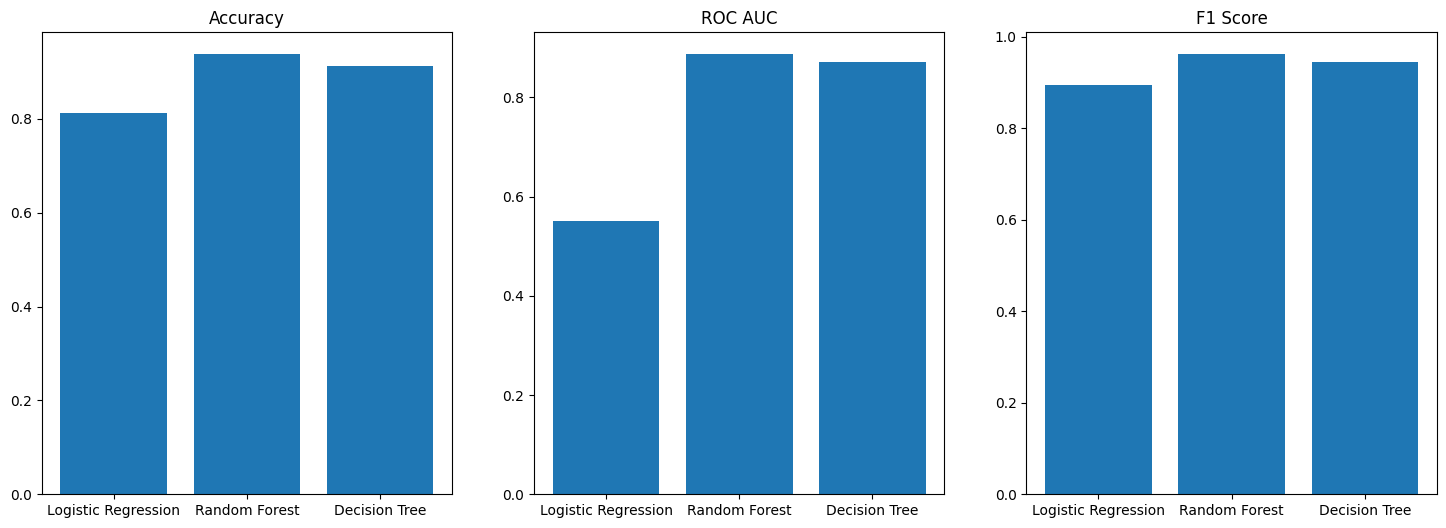

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# 存储每个模型的预测结果
y_preds = [y_pred1, y_pred2, y_pred4]

# 计算 准确率，ROC， F1
accuracies = []
roc_aucs = []
f1s = []
for y_pred in y_preds:
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc)
    f1s.append(f1)
    
# 作图
models = ['Logistic Regression', 'Random Forest', 'Decision Tree']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, metric in enumerate(['Accuracy', 'ROC AUC', 'F1 Score']):
    ax[i].bar(models, [accuracies[j] if i == 0 else roc_aucs[j] if i == 1 else f1s[j] for j in range(3)])
    ax[i].set_title(metric)

plt.show()

根据评分结果，选择Random Forest模型最合适。